# Technical: S1 training with MSE loss

- this notebook will demo how to use CEBRA on the primate reaching data (shown in Fig. 3, Extended Data Fig. 8).
- Specifically, it shows how to use the MSE loss with CEBRA.

- Install note: be sure you have demo dependencies installed to use this notebook: 

In [ ]:
!pip install 'cebra[datasets,demos]'

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA

- Be sure you have downloaded the data and placed `/data` from [FigShare](https://figshare.com/s/60adb075234c2cc51fa3) and into the `demo_notebooks` directory. Let's check if it's there:

In [1]:
ls

Demo_Allen.ipynb                      Demo_learnable_temperature.ipynb
Demo_cohomology.ipynb                 Demo_primate_reaching.ipynb
Demo_consistency.ipynb                Demo_primate_reaching_mse_loss.ipynb
Demo_conv-pivae.ipynb                 Demo_synthetic_exp.ipynb
Demo_decoding.ipynb                   README.rst
Demo_hippocampus.ipynb                data/
Demo_hippocampus_multisession.ipynb   rat_demo_example_output.h5
Demo_hypothesis_testing.ipynb


### Let's load the data:

In [3]:
monkey_pos = cebra.datasets.init('area2-bump-pos-active')
monkey_target = cebra.datasets.init('area2-bump-target-active')

- For a quick CPU run-time demo, you can drop `max_iterations` to 50-500; otherwise set to 5000.

In [4]:
max_iterations = 5000 #default is 5000.

### Define a model that uses positional information as the auxililary variable: 

In [5]:
cebra_pos_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=5e-5,
                        temperature=0.01,
                        output_dimension=2,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

### Fit the model:

In [6]:
cebra_pos_model.fit(monkey_pos.neural, monkey_pos.continuous_index.numpy())
cebra_pos = cebra_pos_model.transform(monkey_pos.neural)

_continuous_index
_discrete_index
delta
_seed
_seed


pos:  0.8407 neg:  4.1718 total:  5.0125: 100%|█████████████████████████████████████████████████████| 5000/5000 [54:33<00:00,  1.53it/s]


### Plot the results:

<IPython.core.display.Javascript object>


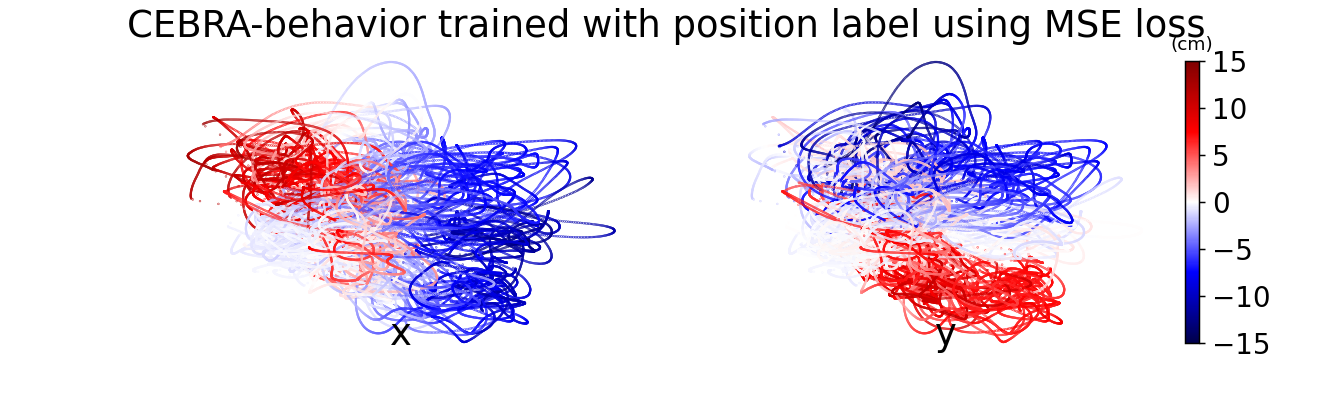

In [16]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 3))
plt.suptitle('CEBRA-behavior trained with position label using MSE loss',
             fontsize=20)
ax = plt.subplot(121)
ax.set_title('x', fontsize=20, y=0)
x = ax.scatter(cebra_pos[:, 0],
               cebra_pos[:, 1],
               c=monkey_pos.continuous_index[:, 0],
               cmap='seismic',
               s=0.05,
               vmin=-15,
               vmax=15)
ax.axis('off')
ax = plt.subplot(122)
y = ax.scatter(cebra_pos[:, 0],
               cebra_pos[:, 1],
               c=monkey_pos.continuous_index[:, 1],
               cmap='seismic',
               s=0.05,
               vmin=-15,
               vmax=15)
ax.axis('off')
ax.set_title('y', fontsize=20, y=0)
yc = plt.colorbar(y, fraction=0.03, pad=0.05, ticks=np.linspace(-15, 15, 7))
yc.ax.tick_params(labelsize=15)
yc.ax.set_title("(cm)", fontsize=10)
plt.show()

### Define a model that uses TARGET information as the auxililary variable: 

In [8]:
cebra_target_model = CEBRA(model_architecture='offset10-model-mse',
                           batch_size=512,
                           learning_rate=5e-5,
                           temperature=0.01,
                           output_dimension=2,
                           max_iterations=max_iterations,
                           distance='euclidean',
                           conditional='time_delta',
                           device='cuda_if_available',
                           verbose=True,
                           time_offsets=10)

In [9]:
cebra_target_model.fit(monkey_target.neural,
                       monkey_target.discrete_index.numpy())
cebra_target = cebra_target_model.transform(monkey_target.neural)

_continuous_index
_discrete_index
_seed


pos:  0.7948 neg:  4.8042 total:  5.5989: 100%|█████████████████████████████████████████████████████| 5000/5000 [02:08<00:00, 38.86it/s]


<IPython.core.display.Javascript object>


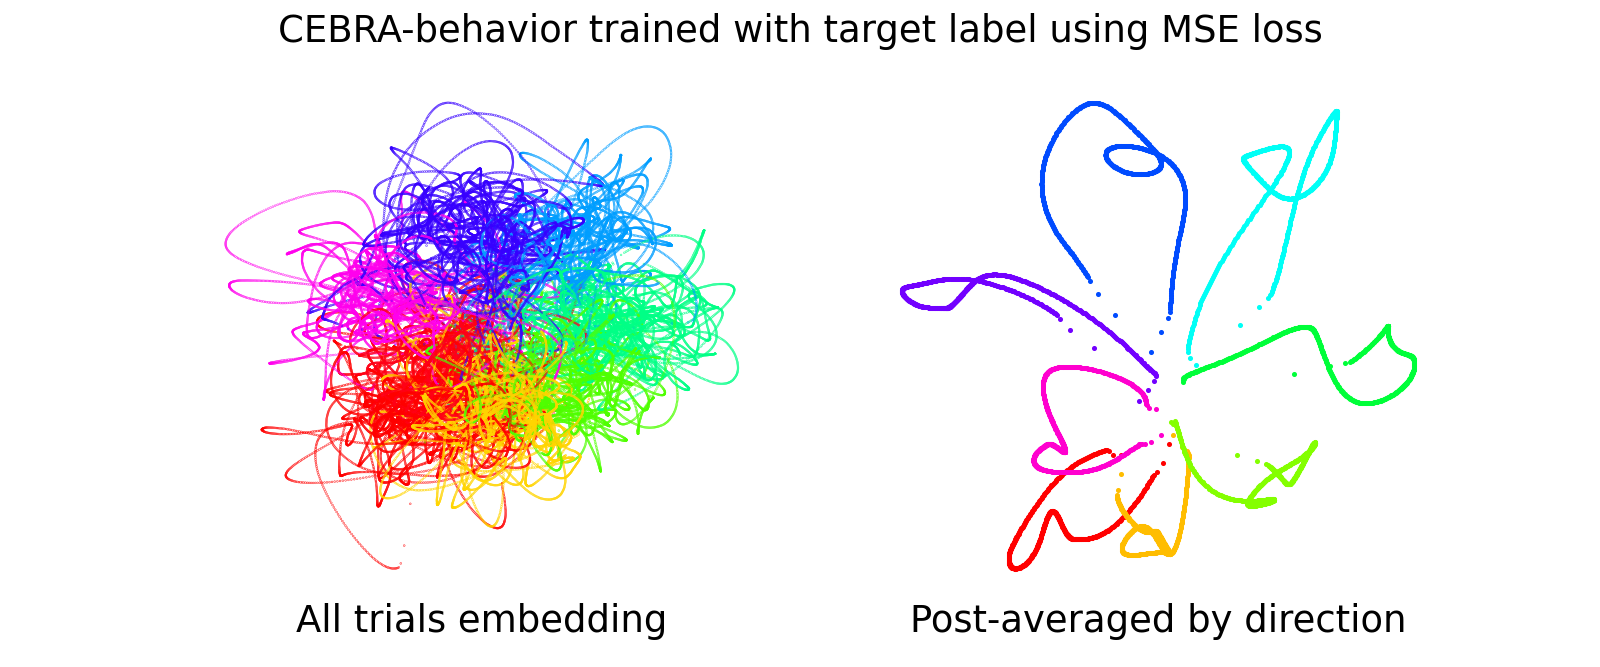

In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(12, 5), dpi=100)
plt.suptitle('CEBRA-behavior trained with target label using MSE loss',
             fontsize=20)
ax = plt.subplot(121)
ax.set_title('All trials embedding', fontsize=20, y=-0.1)
x = ax.scatter(cebra_target[:, 0],
               cebra_target[:, 1],
               c=monkey_target.discrete_index,
               cmap=plt.cm.hsv,
               s=0.05)
ax.axis('off')

ax = plt.subplot(122)
ax.set_title('Post-averaged by direction', fontsize=20, y=-0.1)
for i in range(8):
    direction_trial = (monkey_target.discrete_index == i)
    trial_avg = cebra_target[direction_trial, :].reshape(-1, 600,
                                                         2).mean(axis=0)
    ax.scatter(trial_avg[:, 0],
               trial_avg[:, 1],
               color=plt.cm.hsv(1 / 8 * i),
               s=3)
ax.axis('off')
plt.show()

### Define a model that uses time only information: 

In [11]:
cebra_time_model = CEBRA(model_architecture='offset10-model-mse',
                         batch_size=512,
                         learning_rate=5e-5,
                         temperature=0.01,
                         output_dimension=2,
                         max_iterations=max_iterations,
                         distance='euclidean',
                         conditional='time',
                         device='cuda_if_available',
                         verbose=True,
                         time_offsets=10)

In [12]:
cebra_time_model.fit(monkey_target.neural)
cebra_time = cebra_time_model.transform(monkey_target.neural)

_continuous_index
_discrete_index
_seed


pos:  34206528.0000 neg:  155542336.0000 total:  189748864.0000: 100%|██████████████████████████████| 5000/5000 [02:08<00:00, 38.98it/s]


<IPython.core.display.Javascript object>


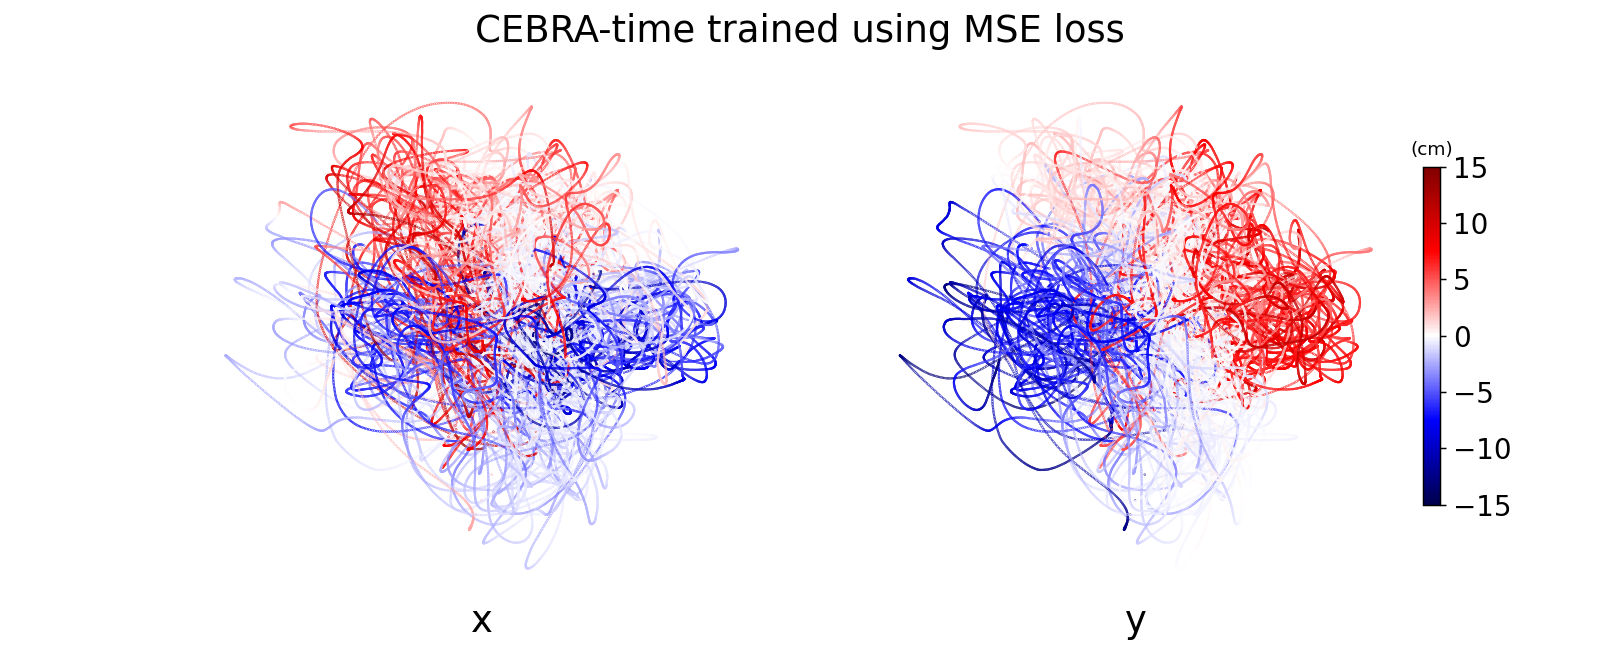

In [14]:
fig = plt.figure(figsize=(12, 5), dpi=100)
plt.suptitle('CEBRA-time trained using MSE loss', fontsize=20)
ax = plt.subplot(121)
ax.set_title('x', fontsize=20, y=-0.1)
x = ax.scatter(cebra_time[:, 0],
               cebra_time[:, 1],
               c=monkey_pos.continuous_index[:, 0],
               cmap='seismic',
               s=0.05,
               vmin=-15,
               vmax=15)
ax.axis('off')
ax = plt.subplot(122)
y = ax.scatter(cebra_time[:, 0],
               cebra_time[:, 1],
               c=monkey_pos.continuous_index[:, 1],
               cmap='seismic',
               s=0.05,
               vmin=-15,
               vmax=15)
ax.axis('off')
ax.set_title('y', fontsize=20, y=-0.1)
yc = plt.colorbar(y, fraction=0.03, pad=0.05, ticks=np.linspace(-15, 15, 7))
yc.ax.tick_params(labelsize=15)
yc.ax.set_title("(cm)", fontsize=10)
plt.show()